In [2]:
%run -i ../init.py

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

# Lecture 15
## Approximate Bayesian computation

As we have seen, exact statistical inference in many genetics problems is often impossible because of the presence of many nuisance parameters. In particular, we often need to integrate over all possible genealogies, which quickly becomes challenging.

## Example: inferring the TMRCA
In the 1990s there was great interest in inferring the time to most recent common ancestor of all humans. That is, given some data $D$ from $n$ samples, we want to estimate $T_n$, the overall height of the coalescent tree for two samples.

Concretely, suppose that 

$$D= 
\pmatrix{
    \texttt{A} &     \texttt{C} &     \texttt{G} &     \texttt{T} \\
        \texttt{A} &     \texttt{A} &     \texttt{G} &     \texttt{T} \\
            \texttt{A} &     \texttt{C} &     \texttt{G} &     \texttt{T} \\
                \texttt{C} &     \texttt{C} &     \texttt{C} &     \texttt{T} 
}.
$$

What is the posterior distribution of $T_4$?

For $n=2$ this is easy enough. We know that $T_2 \sim \mathrm{Exp}(1)$, and that the number of differences between the two sequences is

$$D \mid T_2 \sim \mathrm{Poisson}(\theta T_2)$$ 

under the inifinte sites model. By conjugacy,

$$T_2 \mid D=k \sim \mathrm{Gamma}(1 + k, 1+\theta).$$

For $n>2$, this becomes a more difficult problem: $D$ potentially contains a lot of information about the tree topology and branch lengths, such that the posterior distribution $T_n\mid D$ is difficult to find analytically.

In fact, we cannot even sample from it, because 

$$f_{T_n}(t\mid D) \propto f_{T_n}(t) \mathbb{P}(D\mid T_n=t),$$

and computing $\mathbb{P}(D\mid T_n=t)$ is challenging.

### Conditioning on a summary statistic
Tavaré *et al*. (1997) had the idea of summarizing $D$ by $S_n$, the number of segregating sites in the sample. This is much simpler to reason about, because $S_n$ only depends on the overall *length* of the coalescent tree and not its topology.

In particular, letting $L_n$ be the overall branch length of the coalescent tree on $n$ samples, we have that

$$\mathbb{P}(S_n=k \mid L_n) = \mathrm{Po}(k,L_n\theta/2),$$

where $\mathrm{Po}(\cdot,\mu)$ is the pmf of a $\mathrm{Poisson}(\mu)$ random variable.

Here is a simple and intuitive algorithm for drawing a sample from $T_n \mid S_n=k$:

1. Sample $T_n,L_n$ from the coalescent.
2. Draw $S \sim \mathrm{Pois}(L_n \theta / 2)$.
3. If $S=k$, return $T_n$. 
4. Else, go back to 1.

Let $X$ be the number returned by this algorithm. To check that $X$ has the correct distribution, note that 

\begin{align}
\mathbb{P}(X < t) &= \mathbb{P}(T_n<t \mid S=k) \\
&\propto \mathbb{P}(S = k\mid T_n<t)\, \mathbb{P}(T_n<t)\\
&= \mathbb{E}_{L_n\mid T_n<t} \, \mathrm{Po}(k,L_n\theta/2)  \, \mathbb{P}(T_n<t)\\
&= \mathbb{E}_{L_n\mid T_n<t} \, \mathbb{P}(S_n=k\mid L_n) \mathbb{P}(T_n<t)\\
&= \mathbb{P}(S_n=k, T_n<t) \\
&\propto \mathbb{P}(T_n<t \mid S_n=k).
\end{align}

This algorithm is correct, but it will suffer from many rejections, because frequently we will have $S\neq k$ even if $T_n$ is very close to the true value. Indeed, the probability of acceptance is 

$$\mathbb{P}(S=k) = \mathbb{E}\mathrm{Po}(k,L_n\theta/2).$$

Here is a modified algorithm that has a strictly higher rate of acceptance:


1. Sample $T_n,L_n$ from the coalescent.
2. Draw $U\sim \mathrm{Uniform}(0,1)$.
3. If $U < \frac{\mathrm{Po}(k,L_n \theta/2)}{\mathrm{Po}(k,k)}$, return $T_n$.
4. Else, go back to 1.

The acceptance rate of this algorithm is higher by a factor of $1/c$, where 

$$c=\mathrm{Po}(k,k)<1.$$



To check that it still has the correct distribution, note that

\begin{align}
\mathbb{P}(X < t)& \propto \mathbb{E}_{L_n\mid T_n<t} \, \mathbb{P}\Big(U < \frac{\mathrm{Po}(k,L_n\theta/2)}{c}\Big)  \, \mathbb{P}(T_n<t)\\
&\propto \mathbb{E}_{L_n\mid T_n<t} \, \mathrm{Po}(k,L_n\theta/2)  \, \mathbb{P}(T_n<t).
\end{align}

### Demonstration

In [16]:
def TnLn(n):
    k = np.arange(2, n + 1)
    S = np.random.exponential(scale=2 / k / (k - 1))
    T_n = S.sum()  # height
    L_n = (k * S).sum()  # length
    return T_n, L_n

<IPython.core.display.Javascript object>

In [50]:
import msprime as msp

# simulate a population, get TMRCA and number of mutations
n = 50
theta = 1
tree = msp.simulate(sample_size=n, mutation_rate=theta).first()
tmrca = tree.get_time(tree.root)
k = tree.get_num_mutations()
k

22

<IPython.core.display.Javascript object>

In [81]:
# rejection sample for posterior T_n | S_n = k
from scipy.stats import poisson
from functools import partial

pois = partial(poisson.pmf, k=k)
p_k = pois(mu=k)
spl = []
while len(spl) < 1000:
    T_n, L_n = TnLn(n)
    if np.random.rand() < pois(mu=L_n * theta) / p_k:
        spl.append(T_n)

<IPython.core.display.Javascript object>

(5.231245993035708, 4.79627785010042)

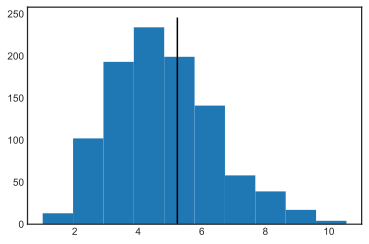

<IPython.core.display.Javascript object>

In [84]:
plt.hist(spl)
plt.vlines(tmrca, *plt.ylim(), color="black")
tmrca, np.mean(spl)

## Approximate Bayesian computation
A more general formulation of the above procedure is:

- Let $S(\cdot):\mathbb{R}^n \to \mathbb{R}^d$ be a function which maps the $n$-dimensional data vector to a $d$-dimension summary statistic;
- Let $K_h(\mathbf{x}):\mathbb{R}^d \to \mathbb{R}$ be a kernel function, with bandwidth $h$, such that $\int K_h(\mathbf{x})\,d\mathbf{x}=1$.

Let the observed data be $\mathbf{y}_\text{obs}$ and $\mathbf{s}_\text{obs}=S(\mathbf{y}_\text{obs})$.

Define

\begin{gather}p(\theta \mid \mathbf{y}_\text{obs}) = \int \pi(\mathbf{y} \mid \theta) K_h(S(\mathbf{y}) - \mathbf{s}_\text{obs})\,d\mathbf{y}\\
\pi_{\text{ABC}}(\theta \mid \mathbf{s}_\text{obs}) \propto \pi(\theta) p(\theta \mid \mathbf{s}_\text{obs})
\end{gather}

Two important facts:
- To get an unbiased estimate of $p(\theta \mid \mathbf{y}_\text{obs})$, we only need to be able to sample from $\pi(\mathbf{y} \mid \theta)$. In many scientific settings, this is easy.
- When $h\to0$, $\pi_{\text{ABC}}(\theta \mid \mathbf{s}_\text{obs}) \to \pi(\theta \mid \mathbf{s}_\text{obs}).$

There are many interesting questions posed by this general formulation:
- How to select the kernel function $K$ and/or bandwidth $h$?
- Most importantly, what is a good choice for $S(\cdot)$? This is by no means obvious.

See the paper by Fearnhead and Prangle (2012) for an in-depth discussion of these issues.

### MCMC ABC
One difficulty with "naive" ABC is that it can have a low acceptance rate. To improve the rate, one proposal is to use MCMC in combination with ABC.

Recall the naive Metropolis-Hastings algorithm:
1. Given an existing parameter $\theta$, sample $\theta' \sim q(\theta\to\theta')$, where $q(\cdot)$ is a proposal distribution.
2. Let $$h = 1\wedge \frac{\mathbb{P}(D\mid \theta')\pi(\theta')q(\theta'\to\theta)}{\mathbb{P}(D\mid \theta)\pi(\theta)q(\theta\to\theta')}.$$
3. With probability $h$, set $\theta=\theta'$; else let it alone.
4. Go to 1.

Once again, if we are in a setting where computing $\mathbb{P}(D\mid \theta)$ is hard, then this algorithm is unworkable. This motivates the following *likelihood-free* variant of MCMC:

1. Given an existing parameter $\theta$, sample $\theta' \sim q(\theta\to\theta')$, where $q(\cdot)$ is a proposal distribution.
2. Generate $D'$ according to $\theta'$.
3. Repeat 2 until $D'=D$.
3. Let $$h=1\wedge \frac{\pi(\theta')q(\theta'\to\theta)}{\pi(\theta)q(\theta\to\theta')}.$$
4. Accept $\theta'$ with probability $h$; else leave it alone.
5. Go to 1.

**Theorem**. The stationary distribution of the above procedure is $f(\theta \mid D)$.

See Marjoram *et al.* (2003) for proof.

Step 2 may have a low probability of succeeding in practice, in which case we could replace it by:

3'. Repeat until $\rho(D,D')<\epsilon$.

or

3''. Repeat until $\rho(S(D),S(D'))<\epsilon$.

Where $\rho$ and $S$ are suitable metrics and summary statistics.

## Example: Y chromosome microsatellites
Pritchard et al (1999) analyzed microsatellite data from 445 human Y chromosomes. The data are [still online](http://web.stanford.edu/group/pritchardlab/dataArchive/ydata.html)!

In [96]:
import pandas as pd

ms = pd.read_csv("microsatellites.txt")
ms

,Sample,DYS19,DYS388,DYS389a,DYS389c,DYS390,DYS391,DYS392,DYS393
0,Australian21,192,128,253,116,216,284,256,124
1,Australian23,192,134,249,116,212,284,250,124
2,Australian25,196,131,249,124,220,284,250,120
3,Australian26,196,131,249,124,220,284,250,120
4,Australian27,196,131,249,124,220,284,250,120
...,...,...,...,...,...,...,...,...,...
440,Zulu47,200,128,253,120,204,284,253,132
441,Zulu49,200,128,253,120,204,284,250,132
442,Zulu77,200,128,253,120,204,284,253,132
443,Zulu80,192,128,257,116,220,284,250,124


<IPython.core.display.Javascript object>

A microsatellite is a small bit of repetitive DNA whose copy number increases or decreases with each generation. Each entry of the above table represents the length of the microsatellite marker. 

Note that the individuals columns have different *repeat lengths*. For example, the first column ([DYS19](https://strbase.nist.gov/str_y19.htm) has repeat length four:

In [103]:
(ms.DYS19 % 4).max()

0

<IPython.core.display.Javascript object>

### Model of microsatellite evolution
Microsatellites evolve differently than the biallelic, infinite sites model that we have been assuming so far. We will assume a *one-step* mutation model, which says that if the repeat count is $p$, then at the next generation, the repeat count $p'$ is 

$$p' = \begin{cases}p+1,&\text{w.p. }\mu/2\\
p-1,&\text{w.p. }\mu/2\\
p,&\text{otherwise}.
\end{cases}
$$

### Estimating $\theta$
The total number of unique haplotypes in this sample is:

In [134]:
ms.drop_duplicates(subset=ms.columns[1:]).shape

(316, 9)

<IPython.core.display.Javascript object>

An estimate of the population-scaled mutation rate is therefore:

In [137]:
316 / np.log(445)

51.81963770499467

<IPython.core.display.Javascript object>

Assuming an effective population size of $N_e=10^4$, we infer that the biological rate of mutation for indels is at least

In [140]:
51.82 / 1e4 / 4

0.0012955

<IPython.core.display.Javascript object>

Which is about 5 orders of magnitude higher than for SNPs. (Note that this is a lower bound, because the infinitely-many alleles model does not apply here.) Thus, microsatellites are useful for studying very recent evolution.

## Simulating microsatellite evolution
To infer evolutionary parameters from microsatellites using ABC, we need to be able to simulate their evolution. We will do this by drawing coalescent trees, and then conditional on the tree, running a stochastic process along its branches. The process runs the mutation model that we described above.

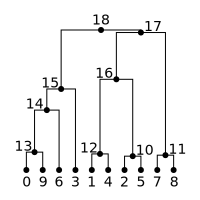

<IPython.core.display.Javascript object>

In [142]:
tree = msp.simulate(sample_size=10, Ne=1e4).first()
SVG(tree.draw())

removed 18, added (15, 17), 20578.652330688696 generations elapse
removed 17, added (11, 16), 13576.673688817427 generations elapse
removed 15, added (3, 14), 8966.09372870404 generations elapse
removed 14, added (6, 13), 2674.768739926026 generations elapse
removed 16, added (10, 12), 2408.1390921731654 generations elapse
removed 13, added (0, 9), 0.0 generations elapse
removed 11, added (7, 8), 0.0 generations elapse
removed 10, added (2, 5), 0.0 generations elapse
removed 12, added (1, 4), 0.0 generations elapse


[3, 6, 0, 9, 7, 8, 2, 5, 1, 4]

<IPython.core.display.Javascript object>

## Example: model of a pandemic
We will use ABC to study the [following model](https://doi.org/10.1093/sysbio/syw077) of infectious disease transmission:
![transmission tree](https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/sysbio/66/1/10.1093_sysbio_syw077/13/m_syw077f2.png?Expires=1606139364&Signature=z4kxa6WjnVsyjdlz8~GbE-7Akwj2DREW6CUEMqpYYb2pLZBu8RByPh-9hiuIch8dh5APMv7igD4I5t-HLTB-7A9XC9yrp788BkidLoOnHfHTWP0APQgrA2HelKd~CEnLfARGWZXG8tF2hDgpnLaci5Zb1Pam7lNN-7OEDzgOrxTqx0yKcEEd5Ah2J0z8eGwt-oQ1r6FL9RXTTG5R6kf2I5JA8OYHCpZAOW17oqG5MKMn6Mbsy~yGxmGxZgEr~j6pOud84O94MR9zNDX5IDSVbh04NBHL0ocgXV7iK0uZYSNO1zt9AqQfq6fcUKUIx-~pu2WYzdtHXMXD3pqECI2KFw__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA)

We can equivalently represent this using a transmission tree:
![transmission tree](https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/sysbio/66/1/10.1093_sysbio_syw077/13/m_syw077f3.png?Expires=1606139364&Signature=LA7uKWX5a8qLSkHdEs5tPMMnxEZMCHUHdPEqrihHvGbn8P0NNPdfTc3qCA-UlbWedrg7wbkxpACxZmNg~cnmiOoL8YXRJqN8NEKhr9AVOFoWHAXWjkRDTsv9NsqqlgjEc1gbFcMy5ozSVHhIa-2lzKXFxZ7h5fgJIOyioQ1rwDENwYe4UuwQJG5A8TKuBxJHO5rJpudler07gJbMcODNQr-luFLGDfnsnX3KemOb2ndXFTjF8lcKxulT-qGAdq5QddTgc2bFRmqjZbnPnSIpKnuVIql3jP~9RBft5svAXbDWAIOTQEGOKM2qRLDUwvkiJBaoLjJ9qbp3KuMZlPHCdQ__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA)

The parameters of this process are $\theta=(\alpha,\delta,\tau)$ which represent the rates of